### Nama: Jonathan Calvin Limawal
### Kode Peserta: PYTN-KS16-019
### Track: Data Science

## 1. Introduction

Pada kesempatan kali ini, saya akan membuat 6 model klasifikasi untuk mengklasifikasikan atau memprediksi apakah klien telah berlangganan deposito berjangka (*Has the client subscribed a term deposit*?). Dataset yang digunakan diambil dari https://archive.ics.uci.edu/dataset/222/bank+marketing dan file dataset yang digunakan adalah 'bank-additional-full.csv'.

Pada dataset ini, ada 20 kolom input (prediktor) dan 1 ada kolom output (target). Selain itu, jumlah data/row pada dataset ini sebanyak 41176 row/data.

Pembuatan mode klasifiaksi ini memuat beberapa bagian/tahap utama:
1. Introduction
2. Dataset
3. Libraries
4. Data Cleaning
5. Data Splitting
6. Data Exploration (EDA)
7. Data Preprocessing
8. Feature Scaling
9. Model Development, Training and Evaluation
10. Algorithm Analysis

# 2. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
from scipy.special import boxcox

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

## 3. Dataset

In [2]:
missing_values = ['n/a', 'na', "--", "?", "NA", 'n-a', 'NaN', ' ', ' - ']

data = pd.read_csv('bank-additional-full.csv', sep=';',  na_values=missing_values)
pd.set_option('display.max_columns', 25)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
data.shape

(41188, 21)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## 4 .Data Cleaning

In [5]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [6]:
total_of_duplicate_data = sum(data.duplicated())
total_of_duplicate_data

12

In [7]:
cleaned_data = data.drop_duplicates()
sum(cleaned_data.duplicated())

0

In [8]:
cleaned_data.shape

(41176, 21)

## 5. Data Splitting

In [9]:
train, test = train_test_split(cleaned_data, test_size=0.2, random_state=42)
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32940, 21)
Test set size: (8236, 21)


## 6. Data Exploration (EDA)

In [10]:
train['default'].value_counts()

no         26107
unknown     6830
yes            3
Name: default, dtype: int64

In [11]:
train = train[train['default'] != 'yes']
test = test[test['default'] != 'yes']

### 6.1 Checking 'y' column distribution

In [12]:
train['y'].value_counts()

no     29269
yes     3668
Name: y, dtype: int64

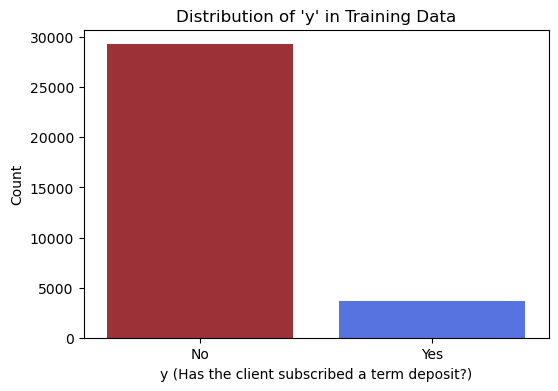

In [13]:
custom_palette = sns.color_palette(["#ae2029", "#4166f5"])
plt.figure(figsize=(6, 4))
sns.countplot(data=train, x='y', palette=custom_palette)
plt.title("Distribution of 'y' in Training Data")
plt.xlabel("y (Has the client subscribed a term deposit?)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

Dari grafik bar di atas, terlihat bahwa **data target kita *imbalanced***. Hal ini menandakan bahwa kita perlu melakukan **RandomOverSampling** nantinya sebelum Feature Scaling untuk mengatasi masalah data yang *imbalanced* ini.

### 6.2 Removing Outliers for age column

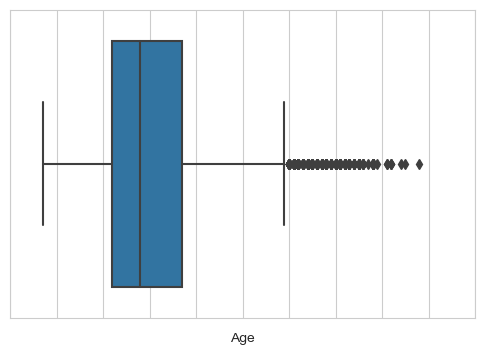

In [14]:
# melihat apakah terdapat outlier pada kolom age
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
boxplot = sns.boxplot(data=train, x='age')
boxplot.set_xticks(boxplot.get_xticks().tolist())
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90, ha="right")
plt.xlabel('Age')
plt.show()

In [15]:
print("Bentuk Shape Lama: ", train.shape)

Q1 = train['age'].quantile(0.25)
Q3 = train['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train = train[(train['age'] >= lower_bound) & (train['age'] <= upper_bound)]

print("Bentuk Shape Baru: ", train.shape)

Bentuk Shape Lama:  (32937, 21)
Bentuk Shape Baru:  (32557, 21)


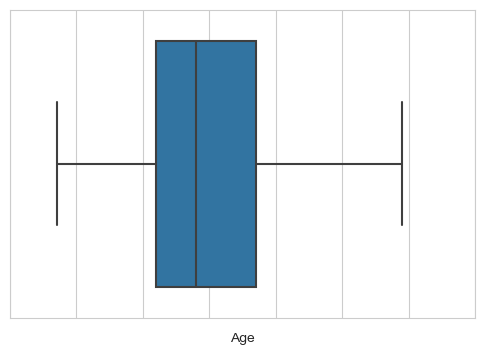

In [16]:
# melihat apakah terdapat outlier pada kolom age
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))
boxplot = sns.boxplot(data=train, x='age')
boxplot.set_xticks(boxplot.get_xticks().tolist())
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=90, ha="right") 
boxplot.set(xticklabels=[])
plt.xlabel('Age')
plt.show()

## 7. Data Preprocessing

### 7.1 Feature Engineering on day_of_week and month column

In [17]:
train['month'].nunique()

10

In [18]:
month_to_quarter_mapping = {
    'mar': '1st Quarter',
    'apr': '2nd Quarter',
    'may': '2nd Quarter',
    'jun': '2nd Quarter',
    'jul': '3rd Quarter',
    'aug': '3rd Quarter',
    'sep': '3rd Quarter',
    'oct': '4th Quarter',
    'nov': '4th Quarter',
    'dec': '4th Quarter'
}

# Create a new column 'quarter' based on the mapping
train['quarter'] = train['month'].map(month_to_quarter_mapping)
test['quarter'] = test['month'].map(month_to_quarter_mapping)

train['time'] = train['day_of_week'] + '_' + train['quarter']
test['time'] = test['day_of_week'] + '_' + test['quarter']

train = train.drop(columns=['month', 'day_of_week', 'quarter'])
test = test.drop(columns=['month', 'day_of_week', 'quarter'])

In [19]:
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32557, 20)
Test set size: (8236, 20)


In [20]:
train.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,time
12348,29,entrepreneur,married,basic.6y,no,yes,yes,telephone,286,3,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no,fri_3rd Quarter
8565,50,admin.,single,university.degree,no,no,no,telephone,178,6,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no,wed_2nd Quarter
21424,29,admin.,single,university.degree,no,no,no,cellular,103,4,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,tue_3rd Quarter
3316,35,admin.,single,university.degree,no,no,no,telephone,135,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no,thu_2nd Quarter
33246,40,blue-collar,single,high.school,unknown,no,no,cellular,418,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no,tue_2nd Quarter


### 7.2 Feature Selection/Reduction

### 7.2.1 Chi-Square Test for categorical columns

H<sub>0</sub>  = Tidak ada korelasi yang signifikan antara kolom 'kategorikal' dan 'y'.

H<sub>1</sub> = Ada korelasi yang signifikan antara kolom 'kategorikal' dan 'y'.

&alpha; = 0.05

Tes = Chi-Square Test

In [21]:
cat_column = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome' , 'time']

y = 'y'

p_values = {}

for column in cat_column:
    contingency_table = pd.crosstab(train[column], train[y])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values[column] = p

for column, p_value in p_values.items():
    print(f"The p-value for {column} is \t: {p_value}")


The p-value for job is 	: 3.2981710930690984e-107
The p-value for marital is 	: 8.075533271157534e-31
The p-value for education is 	: 3.1763017106883045e-34
The p-value for default is 	: 2.565523910692466e-66
The p-value for housing is 	: 0.10563817852313573
The p-value for loan is 	: 0.39089336917862677
The p-value for contact is 	: 3.681169058523178e-138
The p-value for poutcome is 	: 0.0
The p-value for time is 	: 2.0491226182355196e-185


Untuk hasil Chi-Square test pada kolom-kolom di atas, jika p-value > 0.05 (alfa),  hal ini menandakan bahwa tidak ada perbedaan yang signifikan antara kolom tersebut dan 'price'. Oleh karena itu, kita dapat men-drop kolom **'housing'** dan **'loan'**.

In [22]:
train = train.drop(columns=['housing', 'loan'])
test = test.drop(columns=['housing', 'loan'])

In [23]:
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32557, 18)
Test set size: (8236, 18)


### 7.2.2 ANOVA for numerical columns

In [24]:
num_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

results = {}

for column in num_columns:
    groups = [group[column] for name, group in train.groupby('y')]
    f_val, p_val = f_oneway(*groups)
    results[column] = (f_val, p_val)

for column, (f_val, p_val) in results.items():
    print(f'ANOVA for {column}:')
    print('F-value:', f_val)
    print('P-value:', p_val)
    print()

ANOVA for age:
F-value: 8.161232685240103
P-value: 0.004282237471906078

ANOVA for duration:
F-value: 6701.495018019499
P-value: 0.0

ANOVA for campaign:
F-value: 132.17154195861892
P-value: 1.5719567872987735e-30

ANOVA for pdays:
F-value: 3662.4874472598126
P-value: 0.0

ANOVA for previous:
F-value: 1652.4624013353907
P-value: 0.0

ANOVA for emp.var.rate:
F-value: 2969.133308757554
P-value: 0.0

ANOVA for cons.price.idx:
F-value: 575.9709495394485
P-value: 3.530215968404121e-126

ANOVA for cons.conf.idx:
F-value: 72.92448120459815
P-value: 1.4046948322174026e-17

ANOVA for euribor3m:
F-value: 3170.6394604265374
P-value: 0.0

ANOVA for nr.employed:
F-value: 4410.072577248814
P-value: 0.0



### 7.2.3 Final Columns

In [25]:
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32557, 18)
Test set size: (8236, 18)


In [26]:
train.head()

,age,job,marital,education,default,contact,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,time
12348,29,entrepreneur,married,basic.6y,no,telephone,286,3,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no,fri_3rd Quarter
8565,50,admin.,single,university.degree,no,telephone,178,6,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,no,wed_2nd Quarter
21424,29,admin.,single,university.degree,no,cellular,103,4,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,tue_3rd Quarter
3316,35,admin.,single,university.degree,no,telephone,135,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no,thu_2nd Quarter
33246,40,blue-collar,single,high.school,unknown,cellular,418,1,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no,tue_2nd Quarter


### 7.4 One-Hot Encoding

In [27]:
label_encoder = LabelEncoder()

train['y'] = label_encoder.fit_transform(train['y'])
test['y'] = label_encoder.transform(test['y'])

In [28]:
class_labels = label_encoder.classes_
class_encodings = label_encoder.transform(class_labels)

# Create a dictionary to map class labels to their numerical encodings
label_encoding_dict = dict(zip(class_labels, class_encodings))

print("Class Label to Encoding Mapping:")
for label, encoding in label_encoding_dict.items():
    print(f"{label}: {encoding}")

Class Label to Encoding Mapping:
no: 0
yes: 1


In [29]:
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32557, 18)
Test set size: (8236, 18)


In [32]:
cat_column = ['job', 'marital', 'education', 'default', 'contact', 'poutcome' , 'time']

train = pd.get_dummies(train, columns=cat_column, 
                              prefix=cat_column)

test = pd.get_dummies(test, columns=cat_column, 
                              prefix=cat_column)

In [33]:
print("Training set size:", train.shape)
print("Test set size:", test.shape)

Training set size: (32557, 62)
Test set size: (8236, 62)


In [34]:
X_train = train.drop('y', axis=1) 
y_train = train['y']

X_test = test.drop('y', axis=1) 
y_test = test['y']

### 7.5 Resample the Data

In [35]:
X_train,y_train=RandomOverSampler().fit_resample(X_train,y_train)

## 8. Feature Scaling

In [36]:
scaler = MinMaxScaler()

num_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

## 9. Model Development, Training and Evaluation

### 9.1 Logistic Regression

In [37]:
m1 = 'Logistic Regression'
lr = LogisticRegression(max_iter=1000)

model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

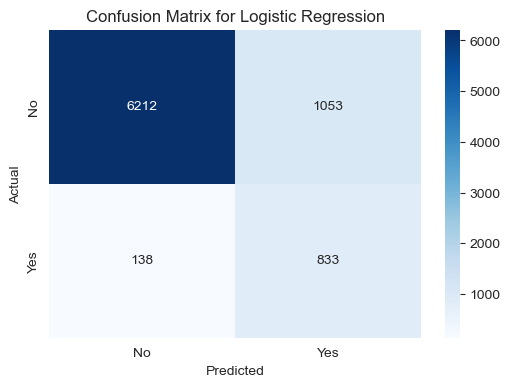

In [38]:
cm = confusion_matrix(y_test, lr_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {m1}')
plt.show()

In [39]:
lr_acc_score = accuracy_score(y_test, lr_predict)
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')

print(classification_report(y_test,lr_predict))

Accuracy of Logistic Regression: 85.53909664885867 

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7265
           1       0.44      0.86      0.58       971

    accuracy                           0.86      8236
   macro avg       0.71      0.86      0.75      8236
weighted avg       0.92      0.86      0.87      8236



### 9.2 K-Nearest Neighbors (KNN)

In [40]:
from sklearn.model_selection import cross_val_score

k_values = [1, 3, 5, 7, 9, 11, 13, 15]

cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_k = k_values[cv_scores.index(max(cv_scores))]

print("Optimal k value:", optimal_k)

Optimal k value: 1


In [41]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)
knn_predict = knn.predict(X_test)

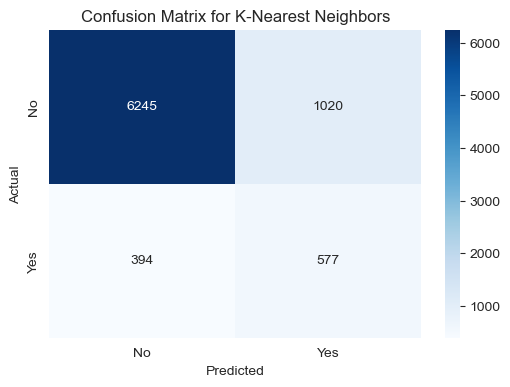

In [42]:
knn_cm = confusion_matrix(y_test, knn_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.show()

In [43]:
knn_acc_score = accuracy_score(y_test, knn_predict)
print("Accuracy of K-Nearest Neighbors:", knn_acc_score * 100, '\n')

print(classification_report(y_test, knn_predict))

Accuracy of K-Nearest Neighbors: 82.83147158814958 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7265
           1       0.36      0.59      0.45       971

    accuracy                           0.83      8236
   macro avg       0.65      0.73      0.67      8236
weighted avg       0.87      0.83      0.85      8236



### 9.3 Support Vector Machine (SVM)

In [44]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_predict = svm.predict(X_test)

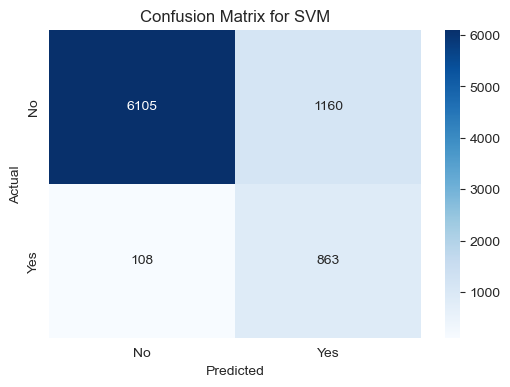

In [45]:
svm_cm = confusion_matrix(y_test, svm_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

In [46]:
svm_acc_score = accuracy_score(y_test, svm_predict)
print("Accuracy of SVM:", svm_acc_score * 100, '\n')

print(classification_report(y_test, svm_predict))

Accuracy of SVM: 84.60417678484701 

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7265
           1       0.43      0.89      0.58       971

    accuracy                           0.85      8236
   macro avg       0.70      0.86      0.74      8236
weighted avg       0.92      0.85      0.87      8236



### 9.4 Decision Tree

In [47]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
dt_predict = decision_tree.predict(X_test)

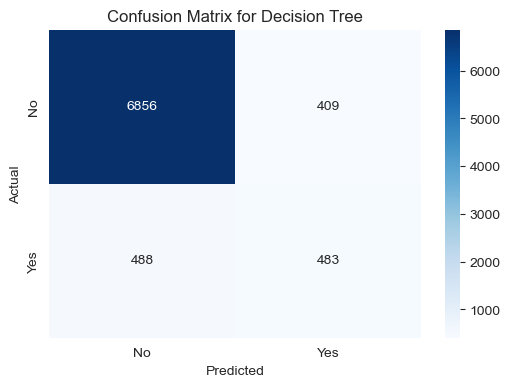

In [48]:
dt_cm = confusion_matrix(y_test, dt_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(dt_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

In [49]:
dt_acc_score = accuracy_score(y_test, dt_predict)
print("Accuracy of Decision Tree:", dt_acc_score * 100, '\n')

print(classification_report(y_test, dt_predict))

Accuracy of Decision Tree: 89.10879067508499 

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7265
           1       0.54      0.50      0.52       971

    accuracy                           0.89      8236
   macro avg       0.74      0.72      0.73      8236
weighted avg       0.89      0.89      0.89      8236



### 9.5 Random Forest

In [50]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_predict = random_forest.predict(X_test)

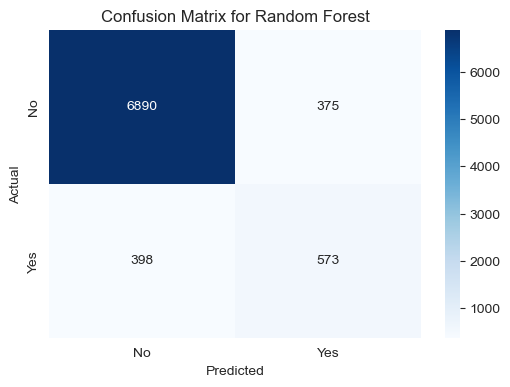

In [51]:
rf_cm = confusion_matrix(y_test, rf_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

In [52]:
rf_acc_score = accuracy_score(y_test, rf_predict)
print("Accuracy of Random Forest:", rf_acc_score * 100, '\n')

print(classification_report(y_test, rf_predict))

Accuracy of Random Forest: 90.61437591063624 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7265
           1       0.60      0.59      0.60       971

    accuracy                           0.91      8236
   macro avg       0.77      0.77      0.77      8236
weighted avg       0.91      0.91      0.91      8236



### 9.6 Naive-Bayes

In [53]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = gnb.predict(X_test)

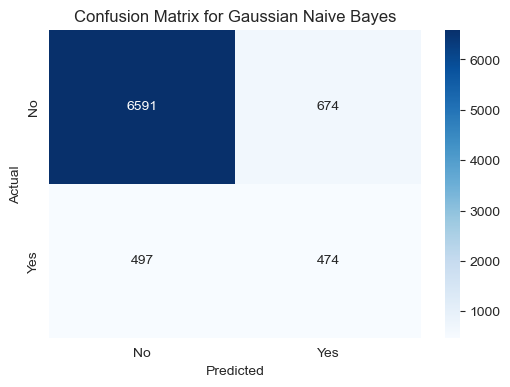

In [54]:
gnb_cm = confusion_matrix(y_test, gnb_predict)

plt.figure(figsize=(6, 4))
sns.heatmap(gnb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gaussian Naive Bayes')
plt.show()

In [55]:
gnb_acc_score = accuracy_score(y_test, gnb_predict)
print("Accuracy of Gaussian Naive Bayes:", gnb_acc_score * 100, '\n')

print(classification_report(y_test, gnb_predict))

Accuracy of Gaussian Naive Bayes: 85.78193297717338 

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7265
           1       0.41      0.49      0.45       971

    accuracy                           0.86      8236
   macro avg       0.67      0.70      0.68      8236
weighted avg       0.87      0.86      0.86      8236



## 10. Algorithm Analysis

Dari hasil *training* dan evaluasi berbagai model/algoritma klasifikasi yang ada, terlihat bahwa model/algortima **Random Forest** memiliki kinerja terbaik di antara model/algoritma yang lain. Model ini memiliki akurasi tertinggi dan skor F1 yang baik dan cukup *reasonable* untuk kelas 1 (yes).

Oleh karena itu, saya memilihi model/algoritma **Random Forest** yang paling sesuai untuk mengklasifikasikan atau memprediksi apakah klien telah berlangganan deposito berjangka (*Has the client subscribed a term deposit*).

Untuk meningkatkan akurasi dan skor F1 dari model yang ada, diperlukan data yang cukup *balanced*, khususnya pada data 'y' (target), atau dapat diterapkan algoritma penanganan ketidakseimbangan kelas (*class imbalance handling algorithms*) yang lainnya untuk menangani masalah *imbalanced data*.